In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys; sys.path.append('..')
import pyzx as zx
import random
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

In [16]:
def clifford_extract(g, left_row, right_row):
    """Given a Clifford diagram in normal form, constructs a Clifford circuit.
    ``left_row`` and ``right_row`` should point to adjacent rows of green nodes
    that are interconnected with Hadamard edges."""
    qubits = g.qubit_count()
    qleft = [v for v in g.vertices() if g.row(v)==left_row]
    qright= [v for v in g.vertices() if g.row(v)==right_row]
    qleft.sort(key=g.qubit)
    qright.sort(key=g.qubit)
    for q in range(qubits):
        no_left = False
        if len(qleft) <= q or g.qubit(qleft[q]) != q: #missing vertex
            vert = max((v for v in g.vertices() if g.qubit(v)==q and g.row(v)<left_row), key=g.row)
            conn = min((n for n in g.neighbours(vert) if g.qubit(n)==q and g.row(n)>=right_row),key=g.row)
            e = g.edge(vert, conn)
            t = g.edge_type(e)
            g.remove_edge(e)
            v1 = g.add_vertex(1,q,left_row)
            g.add_edge((vert,v1),3-t)
            g.add_edge((v1,conn), 2)
            qleft.insert(q,v1)
            no_left = True
        else:
            v1 = qleft[q]
        if len(qright) <= q or g.qubit(qright[q]) != q: #missing vertex
            if no_left: vert = conn
            else: vert = min((v for v in g.vertices() if g.qubit(v)==q and g.row(v)>right_row), key=g.row)
            conn2 = max((n for n in g.neighbours(vert) if g.qubit(n)==q and g.row(n)<=left_row),key=g.row)
            if v1 != conn2: raise TypeError("vertices mismatching")
            e = g.edge(conn2,vert)
            t = g.edge_type(e)
            g.remove_edge(e)
            v2 = g.add_vertex(1,q,right_row)
            g.add_edge((conn2,v2),2)
            g.add_edge((v2,vert),3-t)
            qright.insert(q,v2)  
    
    if len(qleft) != len(qright):
        raise ValueError("Amount of qubits should match on left and right side")
    m = zx.extract.bi_adj(g,qleft,qright)
    if m.rank() != qubits:
        raise ValueError("Adjency matrix rank does not match amount of qubits")
    for v in qright:
        g.set_type(v,2)
        for e in g.incident_edges(v):
            if (g.row(g.edge_s(e)) <= right_row
                and g.row(g.edge_t(e)) <= left_row): continue
            g.set_edge_type(e,3-g.edge_type(e)) # 2 -> 1, 1 -> 2
    c = zx.extract.CNOTMaker(qubits)
    m.gauss(full_reduce=True,x=c)
    c.finish()
    g.replace_subgraph(left_row, right_row, c.g)
    return g

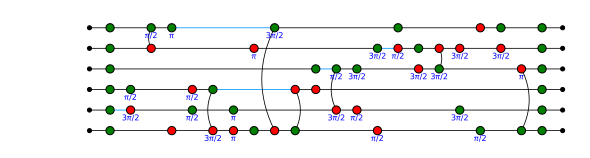

In [37]:
import random
#random.seed(9001)
random.seed(9004)
circ = zx.cliffords(6, 20)
zx.draw(circ)

spider_simp
11. 6. 1. 
finished in 4 iterations
spider_simp
3. 
finished in 2 iterations
pivot_simp
7. 2. 
finished in 3 iterations
lcomp_simp
3. 1. 
finished in 3 iterations
pivot_simp
1. 
finished in 2 iterations
id_simp

finished in 1 iterations
spider_simp

finished in 1 iterations


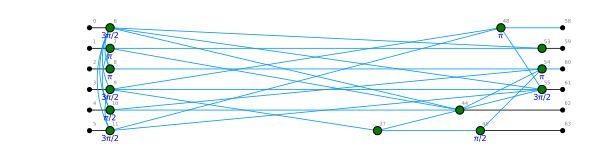

In [38]:
zx.clifford_simp(circ,quiet=False)
#zx.drawing.pack_circuit_nf(circ,'gslc')
#zx.drawing.pack_circuit_rows(circ)
zx.draw(circ,labels=True)

In [46]:
g = circ
v0 = 37
v1 = 55
types = g.types()
phases = g.phases()
v0t = types[v0]
v1t = types[v1]
v0a = phases[v0]
v1a = phases[v1]
print(v0t,v1t,v0a,v1a)
invalid_edge = False
v0n = set()
v0b = set()
for n in g.neighbours(v0):
    #if g.phase(n).denominator > 2:
    #    invalid_edge = True
    #    break
    et = g.edge_type(g.edge(v0,n))
    if n == v1 and et == 2: pass
    elif types[n] == 1 and et == 2: v0n.add(n)
    elif types[n] == 0: v0b.add(n)
    else:
        invalid_edge = True
        break
v0n, v0b

1 1 0 3/2


({9, 46}, set())

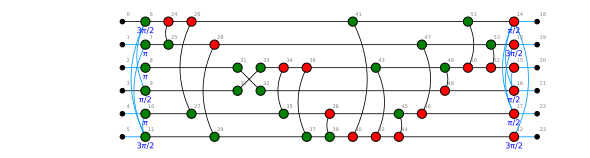

In [18]:
g = circ.copy()
#g.qubit_count()
#vert = min((v for v in g.vertices() if g.qubit(v)==1 and g.row(v)>2), key=g.row)
clifford_extract(g,1,2)
zx.draw(g,labels=True)

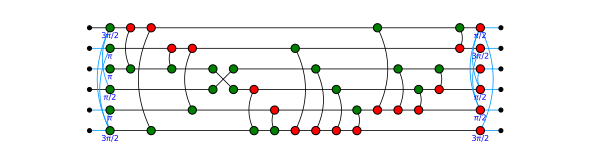

In [21]:
g2 = g.copy()
zx.simplify.clifford_simp(g2, quiet=True)
zx.drawing.pack_circuit_rows(g2)
clifford_extract(g2,1,2)
zx.draw(g2)

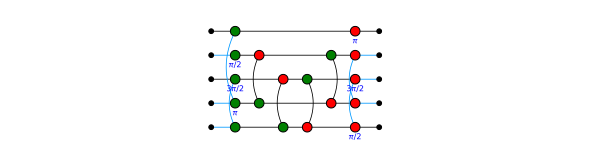

In [39]:
zx.draw(g)

In [5]:
from pyzx.extract import bi_adj
left = []
right = []
for v in circ.vertices():
    if circ.row(v) == 1:
        left.append(v)
    if circ.row(v) == 3:
        right.append(v)

left.sort(key=lambda v: circ.qubit(v))
right.sort(key=lambda v: circ.qubit(v))
#left = [5,6,7,8,9]
#right = [48,51,44,53,54]
qubits = len(left)
m = bi_adj(circ,left,right)
if m.rank() != qubits: print("Error!")
m

from pyzx.extract import CNOTMaker

c = CNOTMaker(qubits)
m.gauss(full_reduce=True,x=c)
c.finish()

[ 1  0  0  0  0 ]
[ 0  1  0  1  0 ]
[ 0  0  1  0  1 ]
[ 0  1  0  0  0 ]
[ 0  0  1  0  0 ]

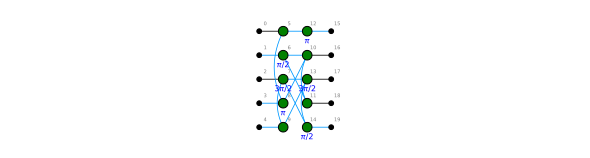

In [28]:
g = circ.copy()
zx.pack_circuit_rows(g)
zx.draw(g,labels=True)

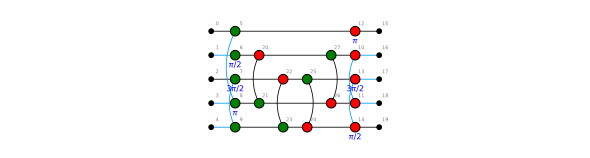

In [30]:
zx.draw(g,labels=True)

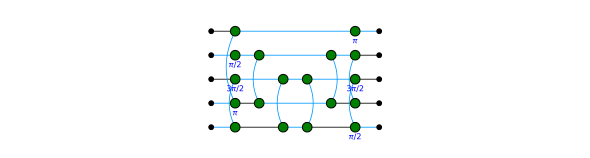

In [25]:
zx.to_gh(g)
zx.draw(g)

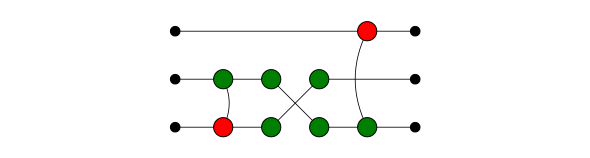

In [11]:
zx.draw(c.g.copy(adjoint=True))

spider_simp
1. 1. 
finished in 3 iterations
spider_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
lcomp_simp

finished in 1 iterations
pivot_simp

finished in 1 iterations
id_simp

finished in 1 iterations


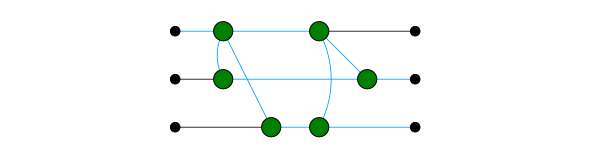

In [139]:
zx.clifford_simp(c.g)
zx.draw(c.g)

In [97]:
connections = {i: set() for i in range(qubits)}
connectionsr= {j: set() for j in range(qubits)}

for i in range(qubits):
        for j in range(qubits):
            if m.data[j][i]: 
                connections[i].add(j)
                connectionsr[j].add(i)

def find_targets(conn, connr, target={}):
    target = target.copy()
    qubits = len(conn)
    claimedr = set(target.values())
    claimed = set(target.keys())
    
    while True: #First determine which qubit should go to which other qubit, before we start adding cnots.
        min_index = -1
        min_options = set(range(1000))
        for i in range(qubits):
            if i in claimed: continue
            s = conn[i] - claimedr
            for i2 in s.copy(): # Go trough the possible options
                for j1 in (connr[i2] - claimed): 
                    if j1 != i and j1 in target and i in connr[target[j1]]: # i connected to j2
                        #This is not allowed
                        print("not allowed1:", i, i2)
                        s.remove(i2)
            if len(s) == 0: return None # No possible options, start backtracking
            if len(s) == 1:
                j = s.pop()
                print("forced1", i,j)
                target[i] = j
                claimed.add(i)
                claimedr.add(j)
                break
            should_break = False
            for i2 in s:
                t = connr[i2] - claimed
                for i1 in t.copy():
                    for j1 in connr[i2]:
                        if j1 != i1 and j1 in target and i1 in connr[target[j1]]: 
                            print("not allowed2:", i1, j1)
                            t.remove(i1)
                if len(t) == 0: return None
                if len(t) == 1: # we must connect them together
                    i1 = t.pop()
                    print("forced2", i1,i2)
                    target[i1] = i2
                    claimed.add(i1)
                    claimedr.add(i2)
                    should_break = True
                    break
            if should_break: break
            if len(s) < len(min_options):
                min_index = i
                min_options = s
        else: # No forced decisions
            if not (conn.keys() - claimed): # we are done
                return target
            if min_index == -1: raise ValueError("This shouldn't happen ever")
            # Start depth-first search
            tgt = target.copy()
            print("backtracking on", min_index)
            for i2 in min_options:
                print("trying option", i2)
                tgt[min_index] = i2
                r = find_targets(conn, connr, tgt)
                if r: return r
            return None
            
            
            
                        
                
#         for v in unclaimed:
#             if v in connections[v]: # We can make a 'straight' connection, so do so
#                 print("straight", v)
#                 target[v] = v
#                 unclaimed.remove(v)
#                 break

target = find_targets(connections, connectionsr)
target

forced2 1 2
forced1 3 4
backtracking on 0
trying option 0
not allowed2: 2 0
trying option 1
not allowed2: 2 0
forced2 4 0
forced1 2 3


{0: 1, 1: 2, 2: 3, 3: 4, 4: 0}

In [102]:
cnots = {i: set() for i in range(qubits)}

for i in range(qubits):
    for j in connections[i]:
        if target[i] == j: continue
        cnots[i].add(j)

for i, tgts in cnots.items():
    for j in tgts:
        #if j <= i: continue
        if i in cnots[j]: print("Conflict: ", i,j)

print(cnots)


Conflict:  0 0
Conflict:  1 1
Conflict:  4 4
{0: {0}, 1: {0, 1, 3}, 2: {0, 1}, 3: set(), 4: {3, 4}}


In [83]:
a = set([1,2,3])
b= set([3,4,5])
c = {1:4, 2:5}
for i in a.copy():
    a.remove(i)
a

set()